In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Using MCMC with the Ising Model ##

Recall the [Ising model](https://en.wikipedia.org/wiki/Ising_model) from statistical mechanics: a discrete mesh (in one or more dimensions) of spins that can be either +1 or −1.  The Ising model is fascinating for many reasons, here we will study it using MCMC methods (in fact the "simplest" such method: [Metropolis-Hastings](https://en.wikipedia.org/wiki/Metropolis–Hastings_algorithm)).
 
The Ising model Hamiltonian (with no external field) is just
$$
H = -J\sum_{\langle a,b\rangle} \sigma_a \sigma_b
$$
with $\sigma\in\{-1,1\}$, $J$ a coupling constant and the sum being over nearest neighbor grid pairs $\langle a,b\rangle$.  We will take $J=1$ for simplicity.

To model this system we need a few routines.  First we initialize our grid randomly, then we need a routine to take an MCMC "step", and finally we need an accept-reject criterion.  For the latter we can use $P\propto\exp[-\beta H]$ for a system at temperature $\beta^{-1}$.  For the former we just need to fill grids with numbers drawn from $\{-1,1\}$ (using ```np.random.choice```).  These can be either spins or things I multiply by in order to flip (or not) spins to take a step.  By controlling the relative probability of 1s and -1s we can control the fraction of spins we flip.

### One dimension ###

Let's starts in 1D.  We will make a periodic line of N "cells" and use MCMC to compute $P(\{\sigma\})$ and hence e.g. $\langle \sigma\rangle$, the mean magnetization or its fluctuations.  Since nothing interesting will really happen in 1D without a "push", we'll add a small external magnetic field to our Hamiltonian just for 1D:

In [2]:
Ng    = 32
spins = np.random.choice([-1,1],size=Ng)
mag   = np.mean(spins)
print("Mean magnetization: ",mag)

Mean magnetization:  0.0625


In [3]:
def hamiltonian(spins):
    si = spins
    sj = np.roll(spins,1)
    hh = -np.sum(si*sj) - 0.1*np.sum(si)
    return(hh)
print("Energy for our current configuration is {:12.4e}".format(hamiltonian(spins)))

Energy for our current configuration is   3.8000e+00


### Metropolis-Hastings ###

The [Metropolis-Hastings](https://en.wikipedia.org/wiki/Metropolis–Hastings_algorithm) algorithm is the simplest Markov chain algorithm to code.  In our context it consists of

1. Make a (reversible) choice of spins to flip.
2. Compute the relative probability of the old and new states using $\Delta H$.
3. Accept "new" with probability ${\rm max}\left(1,\exp[-\beta \Delta H]\right)$.

In [4]:
def mh_step(spins,beta=0.5):
    """Return the next configuration after one MCMC step."""
    old   = spins.copy()
    oldH  = hamiltonian(old)
    flips = np.random.choice([-1,1],size=Ng,p=[0.05,0.95])
    new   = old * flips
    newH  = hamiltonian(new)
    res   = old
    if newH<oldH:
        res = new
    elif np.random.uniform(size=1)<np.exp(-beta*(newH-oldH)):
        res = new
    return(res)

### Visualization ###

We can visualize the time evolution of this MCMC by making a 2D array where 1 axis is spins and the other axis is iterations.

Text(0, 0.5, '$H$')

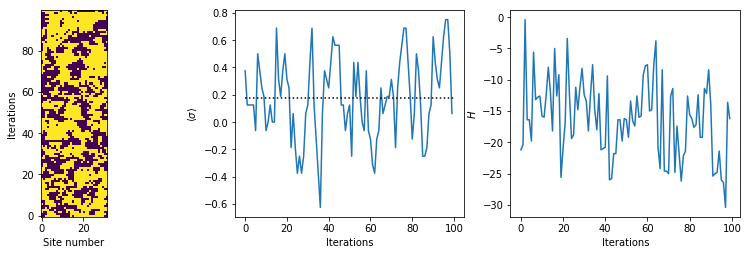

In [5]:
Nstep= 100
Nsub = 50
grid = np.empty( (Ng,Nstep) )
ham  = np.empty( Nstep )
# now run the MCMC:
for burnin in range(500):
    spins = mh_step(spins)
for i in range(Nstep):
    for j in range(Nsub):
        spins = mh_step(spins)
    grid[:,i] = spins.copy()
    ham[i]    = hamiltonian(spins)
#
fig,ax = plt.subplots(1,3,figsize=(14,3.8))
ax[0].imshow(grid.T,origin='lower',interpolation='nearest')
ax[0].set_xlabel(r'Site number')
ax[0].set_ylabel(r'Iterations')
ax[1].plot(np.arange(Nstep),np.mean(grid,axis=0))
ax[1].plot([0,Nstep],[np.mean(grid),np.mean(grid)],'k:')
ax[1].set_xlabel(r'Iterations')
ax[1].set_ylabel(r'$\langle \sigma\rangle$')
ax[2].plot(np.arange(Nstep),ham)
ax[2].set_xlabel(r'Iterations')
ax[2].set_ylabel(r'$H$')

You should be able to "solve" the 1D Ising model analytically, so you can now explore how well the Monte-Carlo matches what you expect.  What do the distributions of your favorite parameters look like?

### Two dimensions ###

Things start to get interesting in 2D, because now there is the possibility of a phase transition (recall the [Peierls argument](https://en.wikipedia.org/wiki/Ising_model#Basic_properties_and_history)).  We'll turn off the external field and see what happens to $\langle\sigma\rangle$.

In [6]:
spins = np.random.choice([-1,1],size=(Ng,Ng))
#
# Let's do a 2D, Cartesian lattice with 4 nearest neighbors per point.
#
def hamiltonian(spins):
    hh  = -np.sum(spins*np.roll(spins,[ 1, 0]))
    hh += -np.sum(spins*np.roll(spins,[-1, 0]))
    hh += -np.sum(spins*np.roll(spins,[ 0, 1]))
    hh += -np.sum(spins*np.roll(spins,[ 0,-1]))
    return(hh)
print("Energy for our current configuration is {:12.4e}".format(hamiltonian(spins)))
#
def mh_step(spins,beta=0.01):
    """Return the next configuration after one MCMC step."""
    old   = spins.copy()
    oldH  = hamiltonian(old)
    flips = np.random.choice([-1,1],size=(Ng,Ng),p=[0.001,0.999])
    new   = old * flips
    newH  = hamiltonian(new)
    res   = old
    if newH<oldH:
        res = new
    elif np.random.uniform(size=1)<np.exp(-beta*(newH-oldH)):
        res = new
    return(res)

Energy for our current configuration is  -9.6000e+01


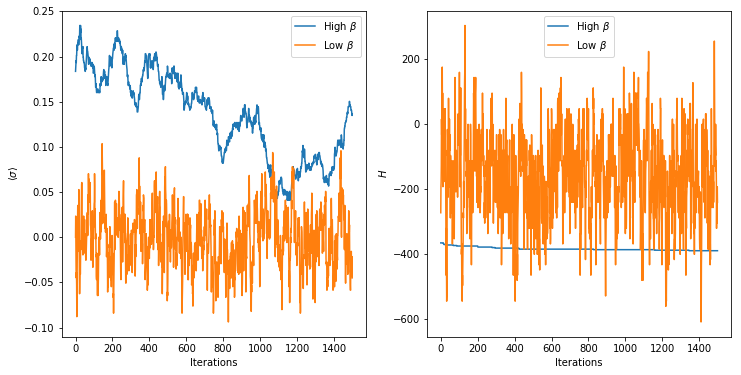

In [9]:
#
# Now run some chains ... this takes quite a while!!!
# It's hard to get this to fully converge in the time
# I often have patience for (!) but you can play with
# the numbers below... also fiddle a bit with the
# probability of a spin flip to see if you can "tune"
# the algorithm for better performance.
#
Nstep= 1500
Nsub = 100
mag  = np.zeros((Nstep,2))
ham  = np.zeros((Nstep,2))
#
# First run the MCMC for "high" beta:
#
spins= np.random.choice([-1,1],size=(Ng,Ng))
beta = 1.0
for burnin in range(50000):
    spins = mh_step(spins,beta)
for i in range(Nstep):
    for j in range(Nsub):
        spins = mh_step(spins,beta)
    mag[i,0] = np.mean(spins)
    ham[i,0] = hamiltonian(spins) / 10.0
#
# and then for "low" beta:
#
spins= np.random.choice([-1,1],size=(Ng,Ng))
beta = 0.01
for burnin in range(100):
    spins = mh_step(spins,beta)
for i in range(Nstep):
    for j in range(Nsub):
        spins = mh_step(spins,beta)
    mag[i,1] = np.mean(spins)
    ham[i,1] = hamiltonian(spins)
#
# and plot the results...
#
fig,ax = plt.subplots(1,2,figsize=(12,6))
ax[0].plot(np.arange(Nstep),mag[:,0],label=r'High $\beta$')
ax[0].plot(np.arange(Nstep),mag[:,1],label=r'Low $\beta$')
ax[0].set_xlabel(r'Iterations')
ax[0].set_ylabel(r'$\langle \sigma\rangle$')
ax[0].legend()
#
ax[1].plot(np.arange(Nstep),ham[:,0],label=r'High $\beta$')
ax[1].plot(np.arange(Nstep),ham[:,1],label=r'Low $\beta$')
ax[1].set_xlabel(r'Iterations')
ax[1].set_ylabel(r'$H$')
ax[1].legend()